# Description 

#### Pycaret documentation
https://pycaret.org/regression/

#### Run inconda env pycaret2_alex

### ToDo
1. annual cross-validation - automated scores to compare metrics
2. test full dataset for individual pixels

## Imports 

In [11]:
#import regression module 
from pycaret.regression import * 

import pandas as pd
%config Completer.use_jedi = False

In [64]:
import matplotlib.pyplot as plt
from sklearn import metrics

## Setting and Setup

#### Data 

In [2]:
PATH_DATA = r'data/INSITU_vs_SAT.csv'

#### Regression 

In [142]:
TARGET = 'a350'
DATA_COLS = ['time', 'Rw400', 'Rw412', 'Rw443', 'Rw490', 'Rw510', 'Rw560',
       'Rw620', 'Rw665', 'Rw674', 'Rw681', 'Rw709', 'Rw754', 'Rw779', 'Rw865',
       'Rw1020']

## Data Loading and preprocessing 

In [143]:
df = pd.read_csv(PATH_DATA)

In [144]:
df.head()

,time,n,Rw400,Rw412,Rw443,Rw490,Rw510,Rw560,Rw620,Rw665,...,Rw754,Rw779,Rw865,Rw1020,ratio,cdom440,cdom375,a254,a350,a443
0,2018-05-30,20,0.010117,0.007851,0.009023,0.011803,0.015951,0.035293,0.032618,0.027384,...,0.012502,0.010208,0.005799,0.001353,2.639883,0.005973,-0.022636,57.289490,14.757243,3.633730
1,2018-05-31,37,0.004514,0.004369,0.004935,0.006927,0.009673,0.018504,0.021040,0.023322,...,0.012732,0.012021,0.007698,0.010300,3.422013,0.020040,0.040916,65.533020,17.227237,4.391385
2,2018-06-01,54,0.002090,0.002488,0.004565,0.006881,0.009211,0.017073,0.022303,0.025289,...,0.014699,0.013754,0.008828,0.011552,3.677898,0.021601,0.048001,73.776550,19.697230,5.149040
3,2018-06-03,36,0.002980,0.003100,0.005143,0.006235,0.008854,0.017334,0.024193,0.029256,...,0.020082,0.019581,0.014587,0.022014,4.312529,0.025584,0.065802,106.558525,28.445500,7.063755
4,2018-06-04,8,0.000987,-0.000062,0.004218,0.010010,0.014556,0.025882,0.038078,0.045455,...,0.049468,0.047743,0.049196,0.050280,4.541117,0.026205,0.068659,122.949512,32.819635,8.021113


In [145]:
df.columns

Index(['time', 'n', 'Rw400', 'Rw412', 'Rw443', 'Rw490', 'Rw510', 'Rw560',
       'Rw620', 'Rw665', 'Rw674', 'Rw681', 'Rw709', 'Rw754', 'Rw779', 'Rw865',
       'Rw1020', 'ratio', 'cdom440', 'cdom375', 'a254', 'a350', 'a443'],
      dtype='object')

#### Adapt datatypes

In [146]:
df.time = pd.to_datetime(df.time)

## Model comparison 
model setup - ET often best/one of best models
  -  to be tested on hold_out set

In [270]:
val_year = 2020
df_filt = (df.query('n > 0')[DATA_COLS + [TARGET]]).dropna()
df_train = df_filt[df.time.dt.year !=val_year]
df_val = df_filt[df.time.dt.year ==val_year]

In [277]:
experiment = setup(df_train, target=TARGET, 
                   remove_multicollinearity=False, 
                   fold_strategy='timeseries', 
                   date_features=['time'],
                   transformation=False,
                   remove_outliers=False, 
                   silent=True,
                   normalize=False,
                   pca=False,
                   verbose=False)

In [294]:
models = compare_models(sort='RMSE')

IntProgress(value=0, description='Processing: ', max=89)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,19:37:01
Status,. . . . . . . . . . . . . . . . . .,Compiling Final Models
Estimator,. . . . . . . . . . . . . . . . . .,Huber Regressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,0.6559,7.1545,0.8458,0.0403,0.0465,0.0482,0.0180
gbr,Gradient Boosting Regressor,2.8780,15.8419,3.6641,0.8083,0.1977,0.1804,0.0190
rf,Random Forest Regressor,3.0502,18.4341,3.8675,0.7845,0.2114,0.1973,0.1170
et,Extra Trees Regressor,3.0688,19.4218,3.9656,0.7606,0.2023,0.1782,0.1120
ada,AdaBoost Regressor,3.1743,20.3630,4.1010,0.7626,0.2131,0.1954,0.0230
ridge,Ridge Regression,3.6071,21.3945,4.3471,0.7512,0.2455,0.2367,0.0140
br,Bayesian Ridge,3.6645,23.3536,4.5154,0.7287,0.2746,0.2396,0.0100
lasso,Lasso Regression,3.9379,21.1788,4.5301,0.7492,0.2678,0.2771,0.0130
knn,K Neighbors Regressor,3.6466,24.0329,4.5394,0.7375,0.2676,0.2746,0.0270
dt,Decision Tree Regressor,4.0127,28.7787,5.1085,0.6387,0.2869,0.2516,0.0120


AttributeError: 'str' object has no attribute 'decode'

#### Holdout metrics

In [296]:
models = create_model('et',verbose=False)
#models = create_model('huber',verbose=False)

In [297]:
trained = predict_model(models, data=df_train)
predicted = predict_model(models, data=df_val)

In [298]:
metrics.mean_squared_error(predicted[TARGET], predicted['Label'])

12.65197933754435

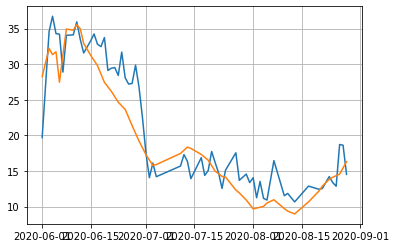

In [299]:
plt.plot_date(predicted.time, predicted.Label, '-')
plt.plot_date(predicted.time, predicted[TARGET], '-')
plt.grid()

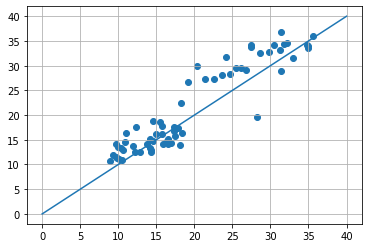

In [300]:
plt.scatter(predicted[TARGET], predicted.Label)
plt.plot([0,40], [0,40], '-')
plt.grid()

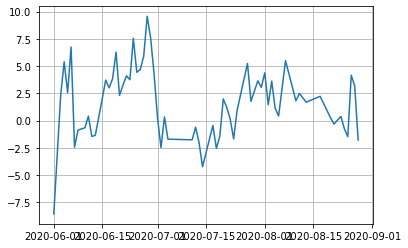

In [301]:
plt.plot_date(predicted.time, predicted.Label-predicted[TARGET], '-')
plt.grid()



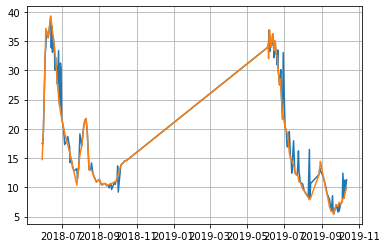

In [199]:
plt.plot_date(trained.time, trained.Label, '-')
plt.plot_date(trained.time, trained[TARGET], '-')
plt.grid()
